## Example deTiN run using data from invitro mixing validation experiment

Loading data : 

In [204]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import deTiN
import deTiN_utilities as du
import deTiN_SSNV_based_estimate as dssnv
import deTiN_aSCNA_based_estimate as dascna
reload(deTiN) ### REMOVE THESE LINES
reload(dssnv)
reload(dascna)
import optparse
args = optparse.Values()
args.mutation_data_path ='example_data/HCC_10_90.call_stats.pon_annotated.txt'
args.cn_data_path = 'example_data/HCC-1143_100_T-sim-final.acs.seg'
args.normal_het_data_path ='example_data/HCC_10_90.normal.hets.tsv'
args.tumor_het_data_path = 'example_data/HCC_10_90.tumor.hets.tsv'
args.output_dir = 'example_data/'
args.output_name = 'HCC_10_90'
args.exac_data_path = '.'
args.mutation_prior = 0.1
args.TiN_prior = 1
di = deTiN.input(args)
di.read_and_preprocess_data()

Estimate tumor in normal based on SSNVs : 

In [205]:
# identify SSNV candidates based on MuTect and panel of normal flags 
di.candidates = du.select_candidate_mutations(di.call_stats_table)
# generate SSNV based model using candidate sites
ssnv_based_model = dssnv.model(di.candidates, di.mutation_prior)
ssnv_based_model.perform_inference()

pre-processing SSNV data
initialized TiN to 0
TiN inference after 1 iterations = 0.11
TiN inference after 2 iterations = 0.11
SSNV based TiN estimate converged: TiN = 0.11


Estimate tumor in normal based on aSCNAs

In [206]:
# filter input SNPs and identify regions of allelic imbalance 
di.aSCNA_hets = du.ensure_balanced_hets(di.seg_table,di.het_table)
di.aSCNA_segs = du.identify_aSCNAs(di.seg_table,di.aSCNA_hets)
# generate aSCNA based model 
ascna_based_model = dascna.model(di.aSCNA_segs, di.aSCNA_hets)
ascna_based_model.perform_inference()

identified convergent aSCNA in normal on chromosomes:[2]
calculating aSCNA based TiN estimate using data from chromosomes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 20]
detected 3 clusters
aSCNA based TiN estimate from modal TiN cluster :  0.13


In [250]:
reload(deTiN)
reload(du)
# calculate joint estimate and recover mutations 
do = deTiN.output(di,ssnv_based_model,ascna_based_model)
do.calculate_joint_estimate()
do.reclassify_mutations()
do.SSNVs.to_csv(path_or_buf=do.input.output_path + '/' + do.input.output_name + '_deTiN_SSNVs.txt',sep='\t')

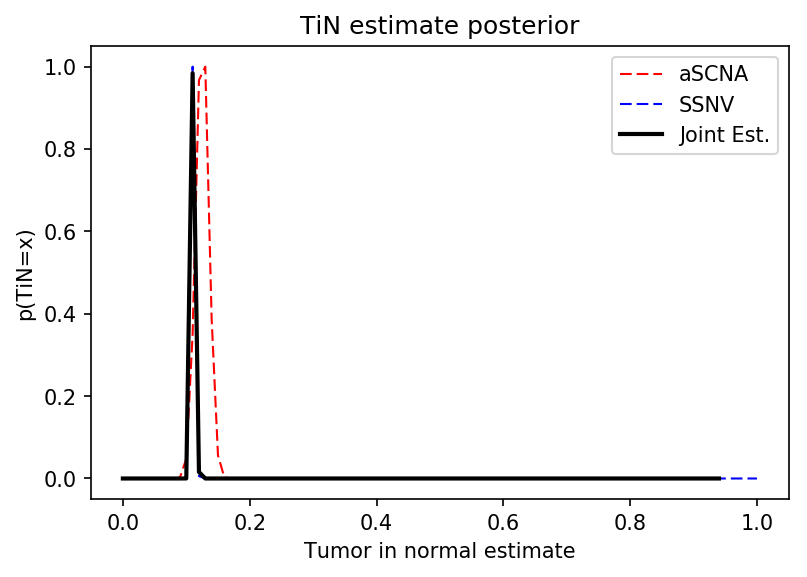

In [222]:
du.plot_TiN_models(do)

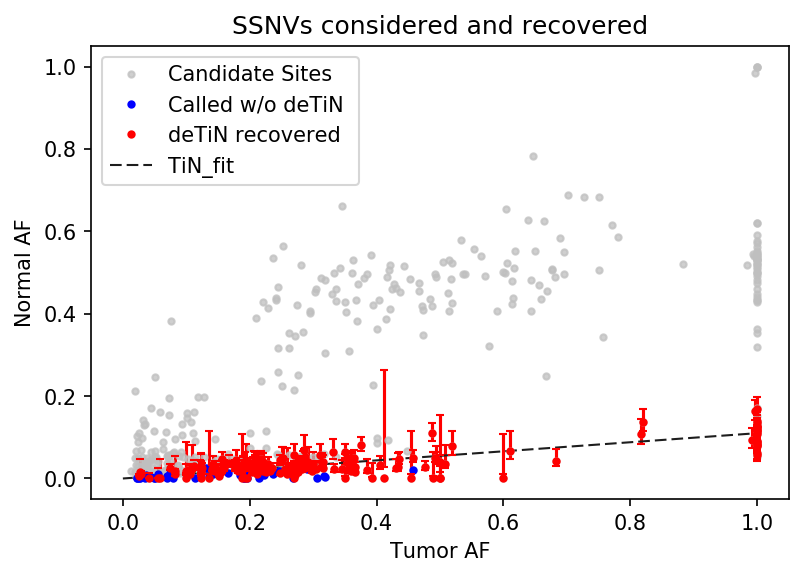

In [223]:
du.plot_SSNVs(do)

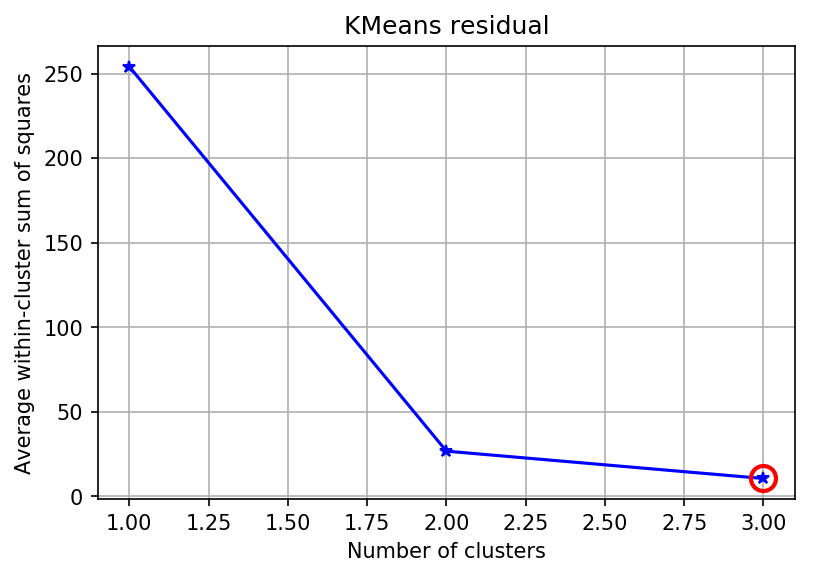

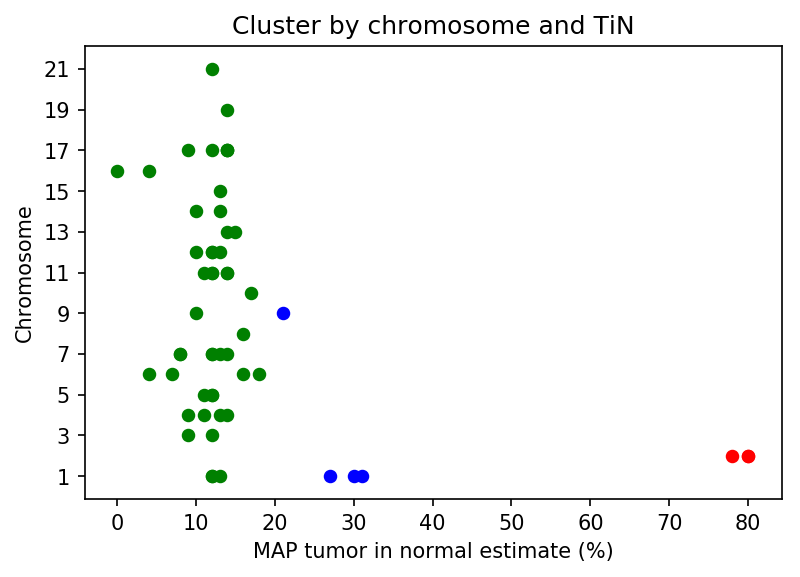

In [251]:
du.plot_kmeans_info(ascna_based_model,do.input.output_path,do.input.output_name)

In [252]:
do.SSNVs

,contig,position,context,ref_allele,alt_allele,tumor_name,normal_name,score,dbsnp_site,covered,...,alt_count_greater10_af_greater_20percent,PoN_Germline,PoN_Artifact,bad,Chromosome,genomic_coord_x,tau,f_acs,p_somatic_given_TiN,p_outlier
0,1,5939677,GTCxCCT,G,C,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.003324,0.004875,0.051629,0,0.0,5939678,2.208582,0.500000,4.256068e-02,1.000000
1,1,6512048,TCTxATC,C,T,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.000000,0.000000,0.020607,0,0.0,6512049,2.208582,0.500000,9.999931e-01,0.256459
2,1,6524705,ACTxCAC,C,A,HCC-1143_100_T,HCC_10_90,0,COSMIC,COVERED,...,0.000000,0.000000,0.050078,0,0.0,6524706,2.208582,0.500000,9.988382e-01,0.407436
3,1,9633452,CCCxAAT,G,A,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.000000,0.000000,0.059827,0,0.0,9633453,1.820760,0.335491,9.064052e-01,0.962172
4,1,9780843,GGGxGCT,A,G,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.000665,0.001108,0.176822,0,0.0,9780844,1.820760,0.335491,6.408561e-01,0.877764
5,1,12064098,TTTxTTG,A,G,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.000000,0.000000,0.020829,0,0.0,12064099,1.820760,0.335491,3.701178e-04,1.000000
6,1,12908213,TAAxTCT,G,A,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.000000,0.001773,0.025704,0,0.0,12908214,1.820760,0.335491,1.135963e-01,0.981408
7,1,16953666,CGGxCTT,T,C,HCC-1143_100_T,HCC_10_90,0,DBSNP,COVERED,...,0.000000,0.000000,0.011079,0,0.0,16953667,1.820760,0.335491,6.531113e-02,1.000000
8,1,16973604,CTGxCGG,C,T,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.000000,0.000000,0.032351,0,0.0,16973605,1.820760,0.335491,5.890895e-02,1.000000
9,1,17026516,CGGxTGC,C,G,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.000886,0.003324,0.024152,0,0.0,17026517,1.820760,0.335491,1.200254e-02,1.000000
